In [111]:
from qiskit import QuantumCircuit, transpile, QuantumRegister
from qiskit.circuit.library import XGate, HGate, ZGate
from qiskit_aer import Aer



In [112]:
num_input = 3
num_qubits = num_input * 2

In [113]:
def multi_cx(qc, controls, anti_controls, target):
    num_controls = len(controls) + len(anti_controls)
    ctrl_state = get_ctrl_state(controls, anti_controls)
    
    new_gate = XGate().control(num_controls, ctrl_state=ctrl_state)
    
    qc.append(new_gate, controls + anti_controls + [target])
    
    return qc

In [114]:
def multi_cz(qc, controls, anti_controls, target):
    num_controls = len(controls) + len(anti_controls)
    ctrl_state = get_ctrl_state(controls, anti_controls)
    new_gate = ZGate().control(num_controls, ctrl_state=ctrl_state)
    
    qc.append(new_gate, controls + anti_controls + [target])
    
    return qc

In [115]:
def get_ctrl_state(controls, anti_controls):
    num_controls = len(controls) + len(anti_controls)
    ctrl_state = ''
    for i in range(num_qubits - 1, -1, -1):
        if i in controls:
            ctrl_state += '1'
        elif i in anti_controls:
            ctrl_state += '0'
        else:
            pass
        pass
    # ctrl_state = ctrl_state[::-1]
    print("ctrl_state", ctrl_state)
    return ctrl_state

ctrl_state 001
ctrl_state 01
ctrl_state 01
ctrl_state 0
ctrl_state 01
ctrl_state 0
ctrl_state 111
ctrl_state 11
ctrl_state 11
ctrl_state 1


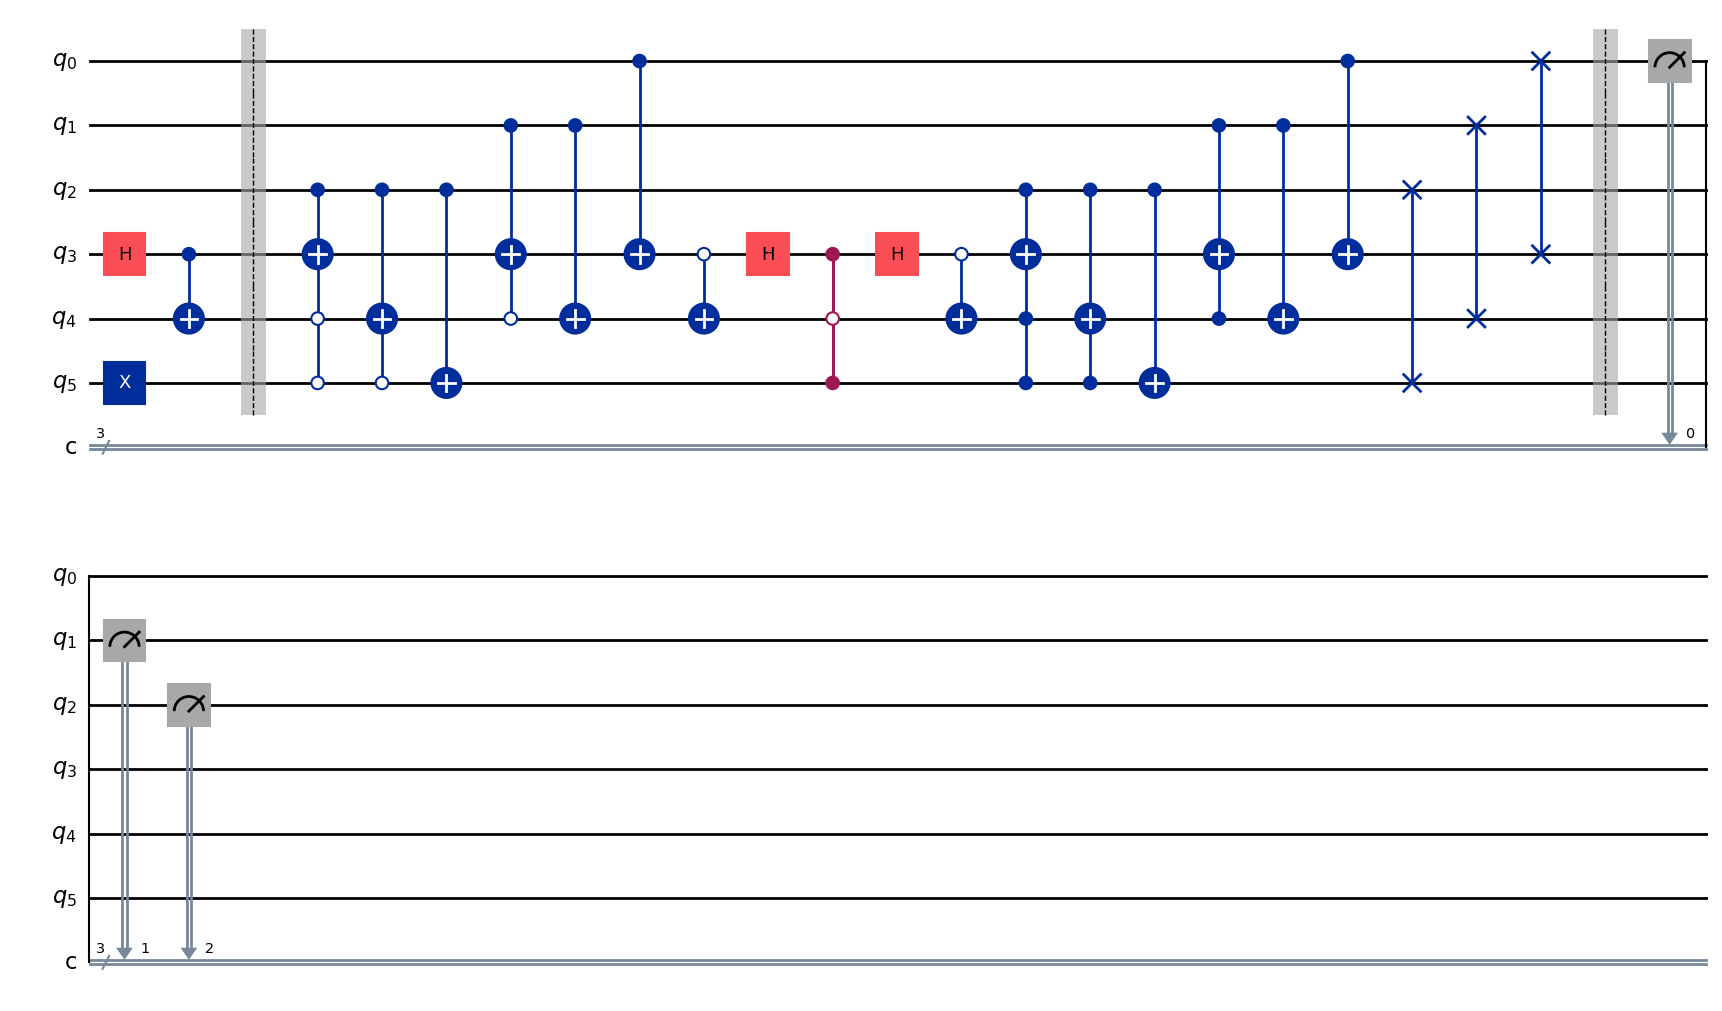

In [116]:


# Create the quantum circuit
qc = QuantumCircuit(num_input * 2, num_input)

# Apply Hadamard coin operator
qc.h(num_input + 0)
qc.x(num_input + 2)
qc.cx(num_input + 0, num_input + 1)
# done with initail setup

qc.barrier()
multi_cx(qc, [2], [num_input + 1, num_input + 2], num_input + 0)
multi_cx(qc, [2], [num_input + 2], num_input + 1)
qc.cx(2, num_input + 2)

multi_cx(qc, [1], [num_input + 1], num_input + 0)
qc.cx(1, num_input + 1)

qc.cx(0, num_input + 0)

multi_cx(qc, [], [num_input + 0], num_input + 1)
qc.h(num_input + 0)
multi_cz(qc, [num_input + 0], [num_input + 1], num_input + 2)
qc.h(num_input + 0)
multi_cx(qc, [], [num_input + 0], num_input + 1)

multi_cx(qc, [2, num_input + 1, num_input + 2], [], num_input + 0)
multi_cx(qc, [2, num_input + 2], [], num_input + 1)
qc.cx(2, num_input + 2)

multi_cx(qc, [1, num_input + 1], [], num_input + 0)
multi_cx(qc, [1], [], num_input + 1)
qc.cx(0, num_input + 0)

qc.swap(2, num_input + 2)
qc.swap(1, num_input + 1)
qc.swap(0, num_input + 0)
qc.barrier()
qc.measure(range(num_input), range(num_input))

qc.draw(output="latex_source", filename="qcircuit.tex")
qc.draw(output="mpl")


# # Simulate the circuit
# simulator = Aer.get_backend("qasm_simulator")
# new_qc = transpile(qc, simulator)
# job = simulator.run(new_qc)
# result = job.result()
# counts = result.get_counts()

# print("Measurement outcomes:", counts)